## Импорт необходимых библиотек

In [79]:
import numpy as np
import pandas as pd
import nltk
import string
import seaborn as sns
import matplotlib.pyplot as plt

nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk import word_tokenize
nltk.download('punkt')
from nltk.probability import FreqDist

!'/Users/sophie/opt/anaconda3/bin/python' -m pip install pymystem3
import pymystem3
from pymystem3 import Mystem
m = Mystem()

!'/Users/sophie/opt/anaconda3/bin/python' -m pip install wordcloud
import wordcloud
from wordcloud import WordCloud


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sophie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/sophie/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Задание

1. Предобработка текстовых данных:
- привести все слова к нижнему регистру
- удалить пунктуацию
- удалить нерелевантные слова (ссылки, слова на английском, и. т .д)
- удалить стоп слова с помощью готовых словарей ( при необходимости дополнить словарь)
- выполнить лемматизацию ( привести все слова в их начальную словоформу)

2. Отсортировать слова по частоте их употребления и выделить топ 100 слов.

Данные: Результаты поисковых запросов по теме “Благотворительность”, собранных системой мониторинга “Крибрум”. 

## Краткое саммари решения

1. Были устранены ошибки в документе и обработанные данные были представлены в виде таблицы  
2. Проведен препроцессинг текста
3. Слова в тексте были токенезированы и лемматизированы
4. Были убраны стоп слова
5. Найдены частотности слов и определен топ-100 
6. Результат был визуализирован

## Этапы решения

### 1. Устранение ошибок и создание датафрейма


Сначала посмотрим, с какими данными мы будем работать, есть ли в них ошибки и пропущенные значения. <br>
Так как из-за имеющихся ошибок данные не могут быть открыты функцией read_csv, используем with open(...)  

Создадим лист, элементами которого будут листы, представляющие собой строки будущего датафрейма, приведенные к нижнему регистру.

In [190]:
data = []
with open('uni_task.csv', encoding="utf8") as lines:
    for line in lines:
        data.append(str(line).lower().split(','))
        
        #data.append(str(line).strip().split(','))

По первой строке заметно, что в нашей будущей таблице будет 5 столбцов <b>(url, author, type, parent_post_url, tag, body)</b> => <br> Чтобы не было ошибок при формировании датафрейма, нужно, чтобы каждый элемент листа <b>data </b> состоял, в свою очередь, из 5 элементов (каждый из которых пойдет в соответствующий столбец). 

Создадим новый лист <b>data1</b>, соответствующий данным требованиям.


In [191]:
data1 = []
for el in data:
    #print(el)
    data_line = []
    for i in range(5):
        data_line.append(el[i])
    #print(len(el[5:]))
        
    if len(el[5:]) > 1:
        data_line.append(",".join(el[5:])) 
    elif len(el[5:]) == 1:
        data_line.append(el[5])
    else:
        data_line.append("")
        
    data1.append(data_line)

Формируем таблицу, заменяем пробелы на NaN и приводим в порядок названия таблицы.

In [193]:
df = pd.DataFrame(data1[1:], columns = data1[0])

In [239]:
df = pd.DataFrame(data1[1:], columns = data1[0])
df = df.rename(columns = {'body;;;;;;;;;;;;;;;;;;;;;;;\n':'body'})
df = df.replace('', np.nan)
df.head()

,url,author,type,parent_post_url,tag,body
0,"""https://vk.com/wall505680146_2821",id505680146,социальные сети,https://vk.com/wall-165936830_65882,0,"""""#show_must_go_on@wazzupbighit#bts#jin#suga#r..."
1,https://vk.com/wall-92124895_6308?reply=6329,id149164749,социальные сети,https://vk.com/wall-92124895_6308,0,а может кто из майкопа есть <fm>доброволец</fm...
2,"""https://vk.com/wall-7138849_2300?reply=2301",lyubars,социальные сети,https://vk.com/wall-7138849_2300,0,"""""сказать сегодня трём людям правдивый комплим..."
3,"""https://vk.com/wall-146345852_579",afishadeti51,социальные сети,https://vk.com/wall-114278140_9723,1,"""""друзья! репост<br>большое социальное меропри..."
4,"""https://vk.com/wall509637155_124",id509637155,социальные сети,https://vk.com/wall-137311321_2416,1,"""""фильм митрополита илариона «сретение»<br>фил..."


Пропуски были найдены в столбцках author и parent_post_url.

In [240]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1001 entries, 0 to 1000
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   url              1001 non-null   object
 1   author           965 non-null    object
 2   type             1001 non-null   object
 3   parent_post_url  469 non-null    object
 4   tag              1001 non-null   object
 5   body             1001 non-null   object
dtypes: object(6)
memory usage: 47.0+ KB


### 2. Препроцессинг текста

Посмотрим на текст в столбце <b>body</b>, в котором будет мусор, чтобы понимать, с чем будем работать.

In [241]:
df.body[0]

'""#show_must_go_on@wazzupbighit#bts#jin#suga#rm#jhope#jimin#taehyung#jungkook<br>[пост будет пополняться]<br>хосок на vlive! «отсчет до hope day».<br>показать полностью…<br>надпись на стене: «дджжеейхооуп, с днем рождения».<br>не может открыть бутылку вина. смеется, говорит, что делает это не в первый раз, чтобы мы не беспокоились.<br>сказал, что хочет провести трансляцию с бокалом вина, потому что чувствует себя счастливым.<br>сказал, что зашел без какой-либо цели, просто поболтать с нами.<br>говорит, что обычно не пьет вино. в комнате отеля была бутылка, так что он решил пробовать. «я не буду много... один бокал... может, два». предупреждает о том, что несовершеннолетним пить нельзя.<br>сказал, что благодарен за то, сколько любви ему подарили. размышлял о том, что, наверное, не стоило говорить на сегодняшнем концерте о том, что он проведет трансляцию, потому что люди, наверное, ожидали чего-то особенного.<br>сказал, что поел набэмоно с остальными мемберами, вернулся в комнату отеля,

Уберем лишние символы, где spec_chars и string.punctuation, которые включены в spec_chars, - элементы, которые нужно удалить.

In [242]:
spec_chars = string.punctuation + '\n\xa0«»<br>\t—…<fm><a</a>' + string.digits + string.ascii_lowercase

In [243]:
spec_chars

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~\n\xa0«»<br>\t—…<fm><a</a>0123456789abcdefghijklmnopqrstuvwxyz'

Из первого столбца необходимо "https:// исправить на https://

В строке string.punctuation знак (") соотносится со значением string.punctuation[1].

In [244]:
def delete_signs_each_str(df, signs_to_delete):
    for index in df.index:
        df.loc[index] = ''.join([ch for ch in df[index] if ch not in signs_to_delete])

In [247]:
delete_signs_each_str(df.body, spec_chars)
delete_signs_each_str(df.url, string.punctuation[1])

In [248]:
df.head()

,url,author,type,parent_post_url,tag,body
0,https://vk.com/wall505680146_2821,id505680146,социальные сети,https://vk.com/wall-165936830_65882,0,пост будет пополнятьсяхосок на отсчет до пок...
1,https://vk.com/wall-92124895_6308?reply=6329,id149164749,социальные сети,https://vk.com/wall-92124895_6308,0,а может кто из майкопа есть доброволец на корр...
2,https://vk.com/wall-7138849_2300?reply=2301,lyubars,социальные сети,https://vk.com/wall-7138849_2300,0,сказать сегодня трём людям правдивый комплимен...
3,https://vk.com/wall-146345852_579,afishadeti51,социальные сети,https://vk.com/wall-114278140_9723,1,друзья репостбольшое социальное мероприятие я...
4,https://vk.com/wall509637155_124,id509637155,социальные сети,https://vk.com/wall-137311321_2416,1,фильм митрополита илариона сретениефильм срете...


### 3. Токенизация и Лемматизация 


### Проведение токенизации

Создадим функцию по токенизации текста.

In [118]:
def tokenize_each_str(df):
    word_list = []
    for index in df.index:
        y = nltk.word_tokenize(df[index])
        word_list.append(y)
    return word_list    

In [119]:
tokenized_txt = tokenize_each_str(df.body)

In [117]:
#создаем новый лист sentences, чтобы избавиться от листов в листах
sentences = []
for sent in word_list:
    sentences += sent

Разбиваем предложения на отдельные слова.

In [95]:
text = ' '.join(sentences)

Всего слов 1820141.

In [96]:
len(text)

1820141

### Проведение лемматизации

In [97]:
lemma = m.lemmatize(text)

### 4.  Удаление стоп-слов

Подгрузим список русских стоп-слов и сохраним как russian_stopwords, добавив в него дополнительные символы, которые не удалились ранее. 

In [132]:
russian_stopwords = stopwords.words('russian')
russian_stopwords.extend(
    ['это', 'нею', 'не', '\n', ' – ', '⠀',
     'который', 'свой', 'г', 'весь', 'очень', 'наш', 'также', 
     'каждый', 'мочь', 'ваш', 'хотя', 'самый', 'свой', 'любой', '№'])


In [120]:
def delete_stop_words(txt):
    sentences_new = []
    for word in txt:
        if word not in russian_stopwords:
            sentences_new.append(word)
    return sentences_new     

In [104]:
sentences_new = delete_stop_words(lemma)

In [105]:
sentences_new

Создадим строку из слов-лемм.

In [133]:
text_lemma = ' '.join(sentences_new)

### 5. Нахождение частотности употребления слов и определение топ-100

Сначала найдем количество повторений каждого слова в тексте.

In [156]:
fdist = FreqDist(sentences_new)

Составим лист из 100 самых частых слов, единичный элемент которого будет представлен в виде кортежа со словом и количеством его повторений.

In [157]:
top_words = fdist.most_common(100)

Для последующей визуализации создадим словарь из 100 самых частых слов. <br> Ключами будут слова, а значениями - их частотность.

In [158]:
dct_top_words = dict((x, y) for x, y in top_words)


### 6. Визуализация

Посмотрим для удобства на 30 самых частых слов, используя столбчатую диаграмму.

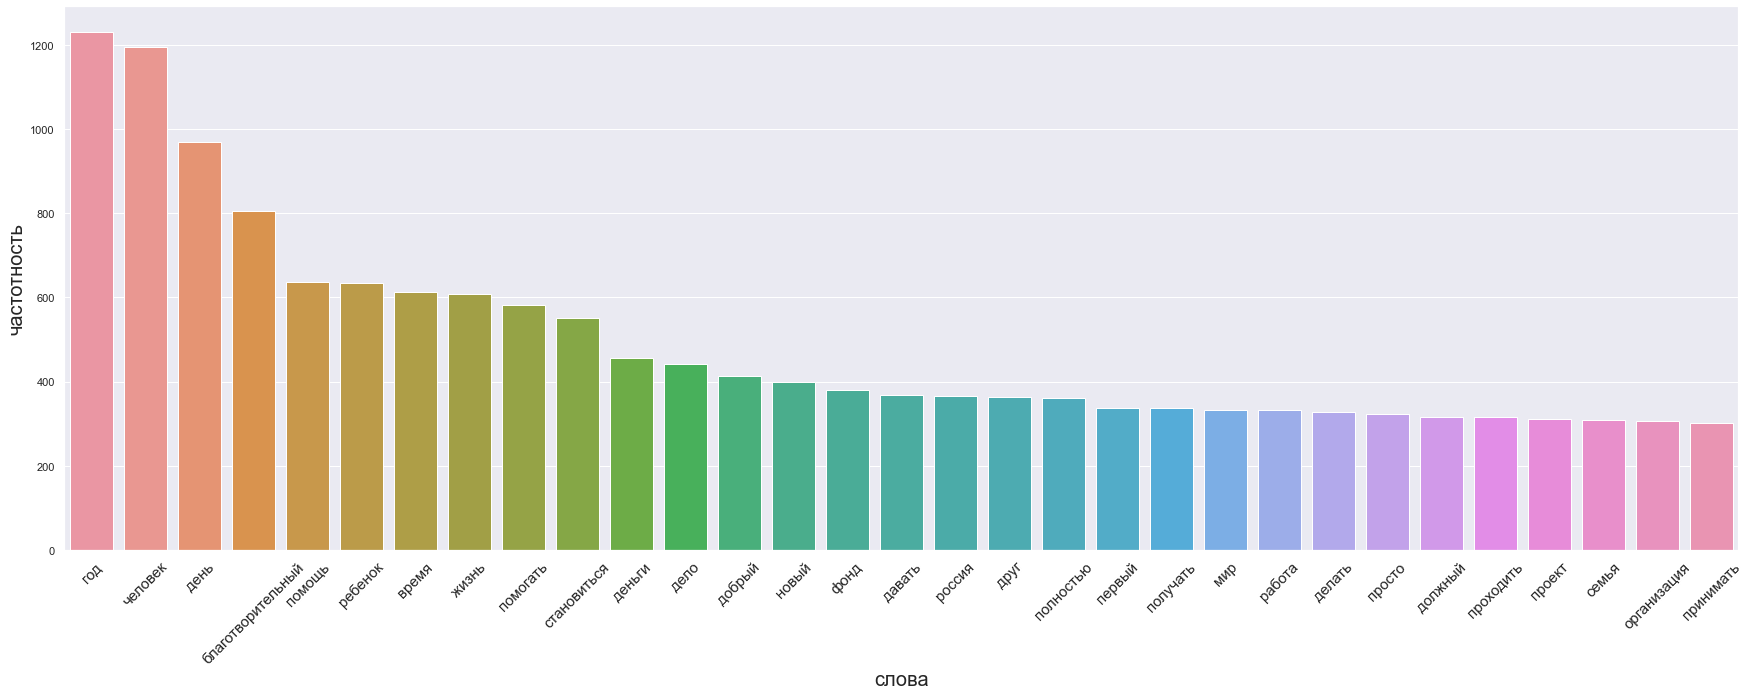

In [160]:
x = list(dct_top_words.keys())[:31]
y = list(dct_top_words.values())[:31]
ax = sns.barplot(x=x, y=y)
plt.xticks(rotation=45, fontsize=15)
sns.set_theme(rc={'figure.figsize': (30, 10)})
ax.set_xlabel('слова', fontsize=20)
ax.set_ylabel('частотность', fontsize=20)
plt.show()

Создадим <b>облако слов</b> (Word Cloud).

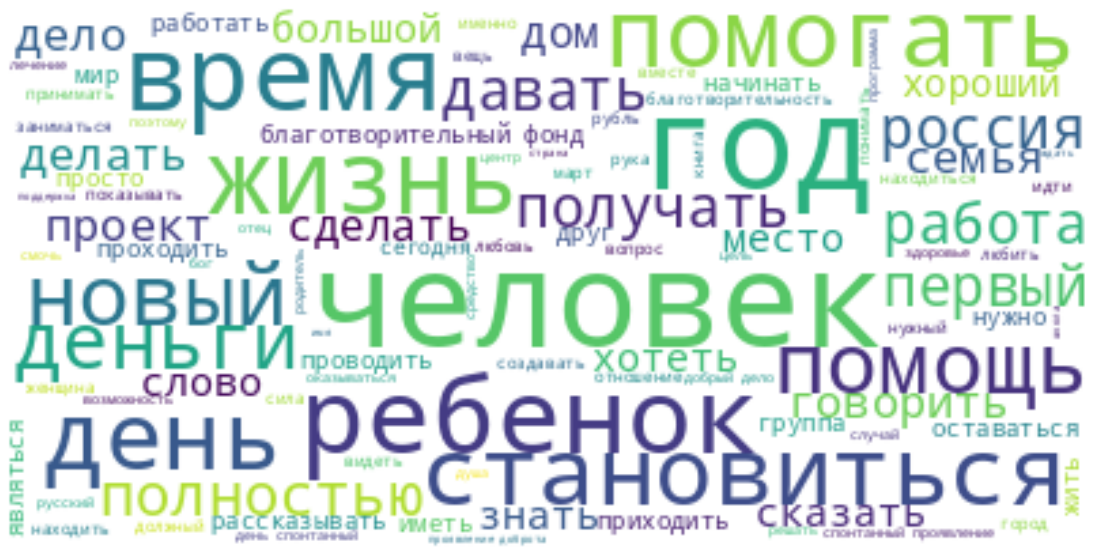

In [166]:
wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text_lemma)

#Выводим облако слов:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()